# TensorFlow Speech Recognition Challenge  
### *Machine Learning Project — Audio Classification with MFCC, Classical Models and CNN*

**Objective:**  
Build and compare multiple machine learning models for spoken command recognition using the Speech Commands dataset on kaggle.


## 1. Introduction

The goal of this project is to build a machine learning system capable of recognizing simple spoken English commands.  
We use the **TensorFlow Speech Recognition Challenge dataset**, which contains 1-second audio clips belonging to 12 categories:

- 10 target commands:  
  **yes, no, up, down, left, right, on, off, go, stop**
- 1 class for other words: **unknown**
- 1 class for background: **silence**

The project follows a complete machine learning pipeline:

. Audio preprocessing using **MFCC features**  
. Dataset construction and handling of class imbalance  
. Training of classical models:
   - Logistic Regression  
   - SVM + PCA  
   
. Training of a **Convolutional Neural Network (CNN)** on MFCC sequences  
. Evaluation with accuracy, classification report, macro-F1, and confusion matrices  
. Comparison and discussion of results

This notebook serves both as the implementation and the technical report of the work.

## 1. Dataset loading
We load the Google Speech Commands dataset and restrict it to 12 classes.

In [1]:
import numpy as np
import os

DATA_DIR = "train/audio"  #path

# List all subfolders in train/audio
folders = sorted([
    d for d in os.listdir(DATA_DIR)
    if os.path.isdir(os.path.join(DATA_DIR, d))
])

print("Found folders:")
for f in folders:
    print("-", f)


Found folders:
- _background_noise_
- bed
- bird
- cat
- dog
- down
- eight
- five
- four
- go
- happy
- house
- left
- marvin
- nine
- no
- off
- on
- one
- right
- seven
- sheila
- six
- stop
- three
- tree
- two
- up
- wow
- yes
- zero


In [3]:
TARGET_WORDS = ["yes","no","up","down","left","right","on","off","stop","go"]
SILENCE_LABEL = "silence"
UNKNOWN_LABEL = "unknown"

ALL_LABELS = TARGET_WORDS + [UNKNOWN_LABEL, SILENCE_LABEL]
print("All labels:", ALL_LABELS)

def get_label_from_path(path):
    """Return the label (one of 12 classes) given an audio file path."""
    folder = os.path.basename(os.path.dirname(path))
    if folder in TARGET_WORDS:
        return folder
    elif folder == "_background_noise_":
        return SILENCE_LABEL
    else:
        return UNKNOWN_LABEL


All labels: ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']


In [4]:
example = "train/audio/yes/0a7c2a8d_nohash_0.wav"
print(get_label_from_path(example))
example = "train/audio/cat/12ab_nohash_1.wav"
print(get_label_from_path(example))

yes
unknown


In [5]:
wav_paths = []
labels = []

for root, dirs, files in os.walk(DATA_DIR):
    folder = os.path.basename(root)
    
    for f in files:
        if f.endswith(".wav"):
            path = os.path.join(root, f)
            wav_paths.append(path)
            labels.append(get_label_from_path(path))


In [6]:
from collections import Counter

print(Counter(labels))


Counter({'unknown': 41039, 'stop': 2380, 'yes': 2377, 'no': 2375, 'up': 2375, 'go': 2372, 'on': 2367, 'right': 2367, 'down': 2359, 'off': 2357, 'left': 2353, 'silence': 6})


## 3. Audio Preprocessing

### MFCC Feature Extraction

Mel-Frequency Cepstral Coefficients (MFCCs) are extracted to represent the spectral envelope of speech signals.

For each audio clip:
- 40 MFCC coefficients are computed per frame
- the result is a 2D matrix (time × frequency)

For classical machine learning models, MFCC matrices are flattened into 1D feature vectors.  
For the CNN, the full 2D structure is preserved.


In [7]:
import librosa

SR = 16000      # target sample rate (16 kHz)
N_MFCC = 40     # number of MFCC coefficients

def load_wav_1s(path, sr=SR):
    """
    Load an audio file and enforce exactly 1 second at 16kHz.
    This is robust to any small variation in length.
    """
    audio, sr = librosa.load(path, sr=sr)
    
    if len(audio) < sr:
        # Pad with zeros at the end if shorter than 1 second
        pad_width = sr - len(audio)
        audio = np.pad(audio, (0, pad_width))
    else:
        # Crop to exactly 1 second if longer
        audio = audio[:sr]
    
    return audio

def extract_mfcc_features(audio, sr=SR, n_mfcc=N_MFCC):
    """
    Extract MFCC features from a 1-second audio signal.
    Returns a flattened 1D vector suitable for classical ML models.
    """
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    # MFCC shape = (n_mfcc, n_frames) -> flatten to 1D vector
    return mfcc.flatten()


In [ ]:
from tqdm import tqdm

X_list = []
y_list = []

print("Building feature matrix")

for path, label in tqdm(zip(wav_paths, labels), total=len(wav_paths)):
    # 1) Load 1-second audio
    audio = load_wav_1s(path)
    
    # 2) Extract MFCC features and flatten
    feats = extract_mfcc_features(audio)
    
    # 3) Store features and label
    X_list.append(feats)
    y_list.append(label)

# Convert to NumPy arrays
X = np.array(X_list)
y = np.array(y_list)

print("X shape:", X.shape)
print("y shape:", y.shape)


Building feature matrix


100%|██████████| 64727/64727 [30:48<00:00, 35.02it/s]    


X shape: (64727, 1280)
y shape: (64727,)


GESTION of FILES BACKGROUND NOISE

In [52]:
X_silence = []
Y_silence = []

noise_path = os.path.join(DATA_DIR, "_background_noise_")
target_sr = 16000  # adapte si ton load_wav_1s utilise autre chose

for file in os.listdir(noise_path):
    if not file.endswith(".wav"):
        continue
    
    path = os.path.join(noise_path, file)
    audio, sr = librosa.load(path, sr=target_sr)

    # Nombre max de segments par fichier (pour éviter l'explosion)
    max_segments = 200
    total_possible = len(audio) // sr
    n_segments = min(max_segments, total_possible)

    # On choisit des positions de départ au hasard pour varier
    if n_segments <= 0:
        continue

    starts = np.random.randint(0, len(audio) - sr, size=n_segments)

    for start in starts:
        temp = audio[start:start+sr]
        if len(temp) < sr:
            continue

        feats = extract_mfcc_features(temp)  # 1D vector, same size as others
        X_silence.append(feats)
        Y_silence.append("silence")

X_silence = np.array(X_silence)
Y_silence = np.array(Y_silence)

print("Generated silence samples:", X_silence.shape[0])

# Ajout à ton X/y AVANT split
X = np.concatenate((X, X_silence), axis=0)
y = np.concatenate((y, Y_silence), axis=0)

Generated silence samples: 398


## 6. MFCC Visualization

We visualize several MFCC representations to better understand how different spoken commands vary in the time–frequency domain.


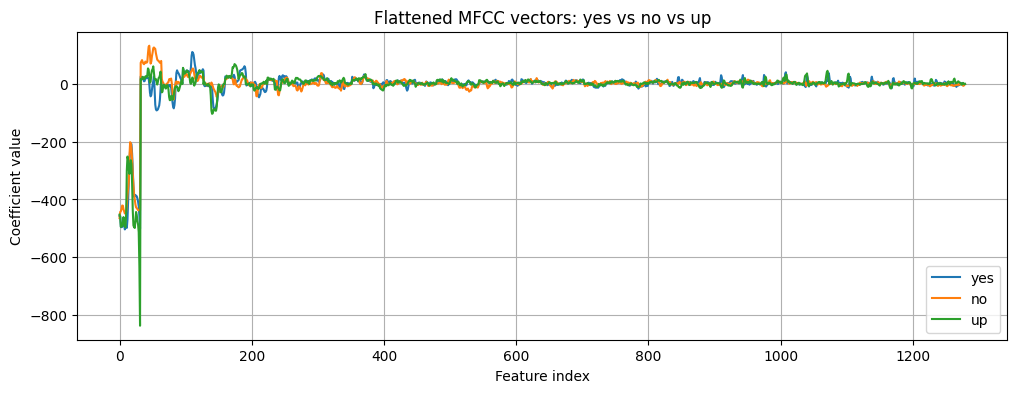

In [53]:
import matplotlib.pyplot as plt

def find_idx(label):
    for i, l in enumerate(y):
        if l == label:
            return i
    return None

idx_yes = find_idx("yes")
idx_no = find_idx("no")
idx_up = find_idx("up")


sample_idx = [idx_yes, idx_no, idx_up]
labels_list = ["yes", "no", "up"]

plt.figure(figsize=(12, 4))  

for idx, lab in zip(sample_idx, labels_list):
    mfcc_vector = X[idx]  
    plt.plot(mfcc_vector, label=lab)   

plt.title("Flattened MFCC vectors: yes vs no vs up")
plt.xlabel("Feature index")
plt.ylabel("Coefficient value")
plt.grid(True)
plt.legend()
plt.show()

Visualisation of some audio of yes 

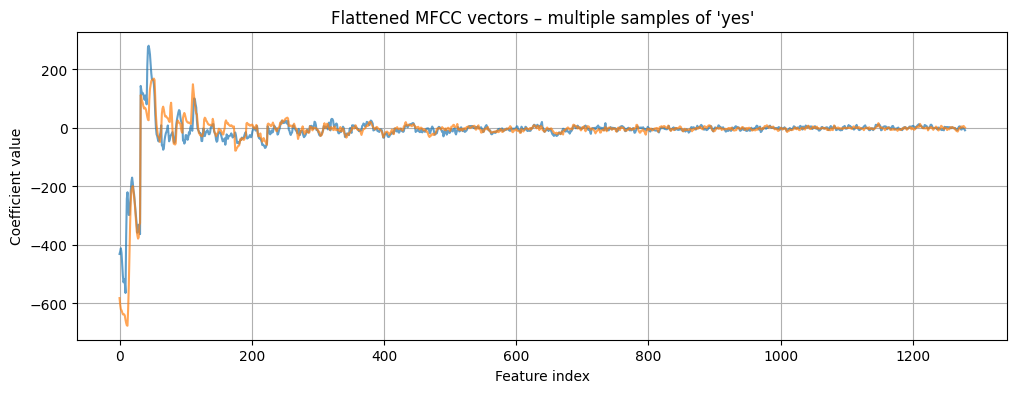

In [ ]:
indices_yes = [i for i, l in enumerate(y) if l == "yes"]

plt.figure(figsize=(12, 4))

for idx in indices_yes[567:569]:
    mfcc_vector = X[idx]
    plt.plot(mfcc_vector, alpha=0.7)

plt.title("Flattened MFCC vectors – multiple samples of 'yes'")
plt.xlabel("Feature index")
plt.ylabel("Coefficient value")
plt.grid(True)
plt.show()

## 7. Data Preparation

The dataset is split into training and validation sets using a stratified strategy to preserve class distribution.

Features are standardized when required by the learning algorithm.


In [55]:
#Train/Test Split 

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,      # 20% 
    random_state=0,
    stratify=y          
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Train shape: (52880, 1280)
Validation shape: (13221, 1280)


In [56]:
#Encode labels : y 

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)

print("Classes encoded as:", list(label_encoder.classes_))
print(y_val_enc[:5])

Classes encoded as: [np.str_('down'), np.str_('go'), np.str_('left'), np.str_('no'), np.str_('off'), np.str_('on'), np.str_('right'), np.str_('silence'), np.str_('stop'), np.str_('unknown'), np.str_('up'), np.str_('yes')]
[ 9  5  9 11  9]


In [2]:
#Standardisation of features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_val_scaled = scaler.transform(X_val)


NameError: name 'X_train' is not defined

## 8. Logistic Regression Baseline

A multinomial Logistic Regression model is trained on flattened MFCC features.

This model serves as a **baseline** to evaluate the limitations of linear classifiers on speech data.


c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy: 0.6482111791846306

Classification Report:
              precision    recall  f1-score   support

        down       0.26      0.09      0.13       472
          go       0.32      0.11      0.16       475
        left       0.37      0.15      0.21       471
          no       0.26      0.09      0.14       475
         off       0.44      0.39      0.41       471
          on       0.42      0.29      0.34       473
       right       0.24      0.07      0.11       473
     silence       0.98      0.99      0.98       276
        stop       0.52      0.32      0.40       476
     unknown       0.70      0.89      0.78      8208
          up       0.34      0.20      0.25       475
         yes       0.54      0.42      0.48       476

    accuracy                           0.65     13221
   macro avg       0.45      0.33      0.37     13221
weighted avg       0.59      0.65      0.60     13221



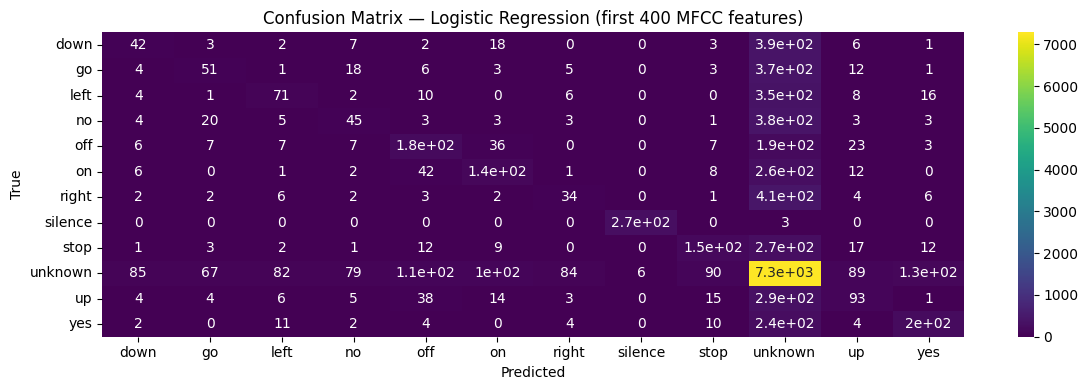

In [ ]:
#MODEL 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    max_iter=200,
    solver='lbfgs',
    multi_class='multinomial',
    n_jobs=-1,
    #class_weight='balanced'
)

logreg.fit(X_train_scaled, y_train_enc)

from sklearn.metrics import accuracy_score, classification_report

y_pred = logreg.predict(X_val_scaled)

acc = accuracy_score(y_val_enc, y_pred)
print("Validation Accuracy:", acc)

print("\nClassification Report:")
print(classification_report(y_val_enc, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix (colored heatmap) 
cm = confusion_matrix(y_val_enc, y_pred)

plt.figure(figsize=(12, 4))
sns.heatmap(
    cm,
    annot=True,        
    cmap="viridis",      
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## 9. Logistic Regression with Class Balancing

A second Logistic Regression model is trained using:
- class weighting to compensate for class imbalance
- partial feature selection based on MFCC variance

This experiment evaluates whether simple adjustments can improve performance.


c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy: 0.3610165645563876

Classification Report:
              precision    recall  f1-score   support

        down       0.18      0.45      0.26       472
          go       0.20      0.42      0.27       475
        left       0.23      0.48      0.32       471
          no       0.18      0.40      0.25       475
         off       0.35      0.58      0.44       471
          on       0.26      0.53      0.35       473
       right       0.15      0.51      0.24       473
     silence       0.86      1.00      0.93       276
        stop       0.29      0.61      0.39       476
     unknown       0.88      0.25      0.39      8208
          up       0.22      0.42      0.29       475
         yes       0.30      0.74      0.43       476

    accuracy                           0.36     13221
   macro avg       0.34      0.53      0.38     13221
weighted avg       0.65      0.36      0.38     13221



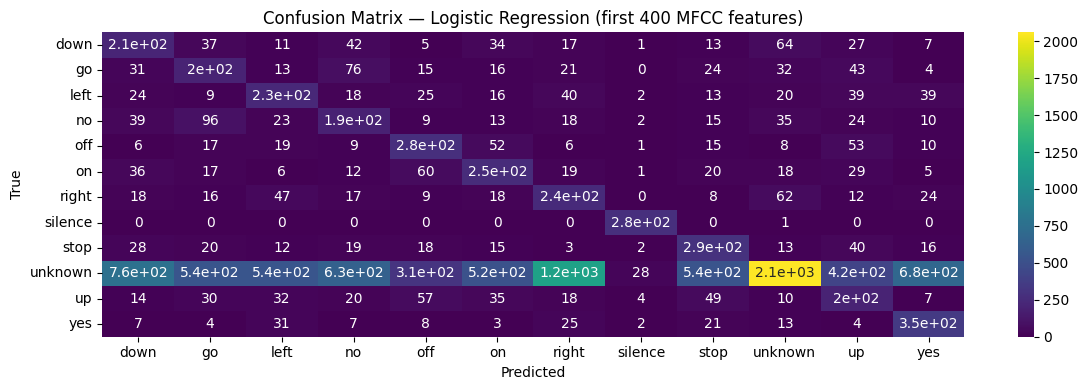

In [62]:
# === 1) Restrict train & validation to first 400 MFCC features ===
X_train_400 = X_train_scaled[:, :400]
X_val_400   = X_val_scaled[:, :400]

# === 2) Define and train the model ===
logreg1 = LogisticRegression(
    max_iter=200,
    solver='lbfgs',
    multi_class='multinomial',
    n_jobs=-1,
    class_weight='balanced'
)

logreg1.fit(X_train_400, y_train_enc)

# === 3) Predict ===
y_pred = logreg1.predict(X_val_400)

# === 4) Metrics ===
acc = accuracy_score(y_val_enc, y_pred)
print("Validation Accuracy:", acc)

print("\nClassification Report:")
print(classification_report(y_val_enc, y_pred, target_names=label_encoder.classes_))

# === 5) Confusion Matrix (colored heatmap) ===
cm = confusion_matrix(y_val_enc, y_pred)

plt.figure(figsize=(12, 4))
sns.heatmap(
    cm,
    annot=True,        
    cmap="viridis",      
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title("Confusion Matrix — Logistic Regression (first 400 MFCC features)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

LOGISTIC REGRESSION AND PCA

In [63]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# === PCA + Logistic Regression model ===
logreg_pca = Pipeline([
    ("pca", PCA(n_components=50)),   # reduce dimensionality of MFCC features
    ("logreg", LogisticRegression(
        max_iter=200,
        solver='lbfgs',
        multi_class='multinomial',
        n_jobs=-1,
        #class_weight='balanced'
    ))
])

# === Train on scaled features ===
logreg_pca.fit(X_train_scaled, y_train_enc)


c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,steps,"[('pca', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_components,50
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10


In [64]:
y_pred_log_pca = logreg_pca.predict(X_val_scaled)

acc = accuracy_score(y_val_enc, y_pred_log_pca)
print("Validation Accuracy:", acc)

print("\nClassification Report:")
print(classification_report(y_val_enc, y_pred_log_pca, target_names=label_encoder.classes_))

Validation Accuracy: 0.6538839724680433

Classification Report:
              precision    recall  f1-score   support

        down       0.00      0.00      0.00       472
          go       0.22      0.02      0.03       475
        left       0.44      0.03      0.06       471
          no       0.19      0.01      0.02       475
         off       0.47      0.36      0.41       471
          on       0.49      0.19      0.27       473
       right       0.19      0.01      0.02       473
     silence       0.98      0.99      0.99       276
        stop       0.50      0.21      0.30       476
     unknown       0.67      0.95      0.78      8208
          up       0.35      0.10      0.16       475
         yes       0.53      0.26      0.35       476

    accuracy                           0.65     13221
   macro avg       0.42      0.26      0.28     13221
weighted avg       0.56      0.65      0.57     13221



## 10. Support Vector Machine with PCA

To capture non-linear decision boundaries, we train an SVM with an RBF kernel.

Due to the high dimensionality of flattened MFCC features, PCA is applied prior to SVM training.


In [70]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    confusion_matrix
)

# === 1) Define SVM + PCA pipeline ===
svm_model = Pipeline([
    ("pca", PCA(n_components=50)),          # reduce dimension, keep most variance
    ("svm", SVC(kernel="rbf", C=5, gamma="scale"))
])

In [71]:
# === 2) Train on full scaled MFCC features ===
print("Training SVM + PCA...")
svm_model.fit(X_train_scaled, y_train_enc)

Training SVM + PCA...


,steps,"[('pca', ...), ('svm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_components,50
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10


In [72]:
# === 3) Predict on validation set ===
y_pred_enc_svm = svm_model.predict(X_val_scaled)

SVM + PCA - Validation Accuracy: 0.7473350841958907

SVM + PCA - Classification Report (all classes):
              precision    recall  f1-score   support

        down       0.65      0.12      0.21       472
          go       0.59      0.23      0.33       475
        left       0.69      0.38      0.49       471
          no       0.61      0.16      0.26       475
         off       0.70      0.55      0.62       471
          on       0.68      0.41      0.51       473
       right       0.79      0.33      0.46       473
     silence       0.00      0.00      0.00         1
        stop       0.85      0.67      0.75       476
     unknown       0.75      0.95      0.84      8208
          up       0.66      0.43      0.52       475
         yes       0.84      0.63      0.72       476

    accuracy                           0.75     12946
   macro avg       0.65      0.41      0.48     12946
weighted avg       0.74      0.75      0.71     12946



c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

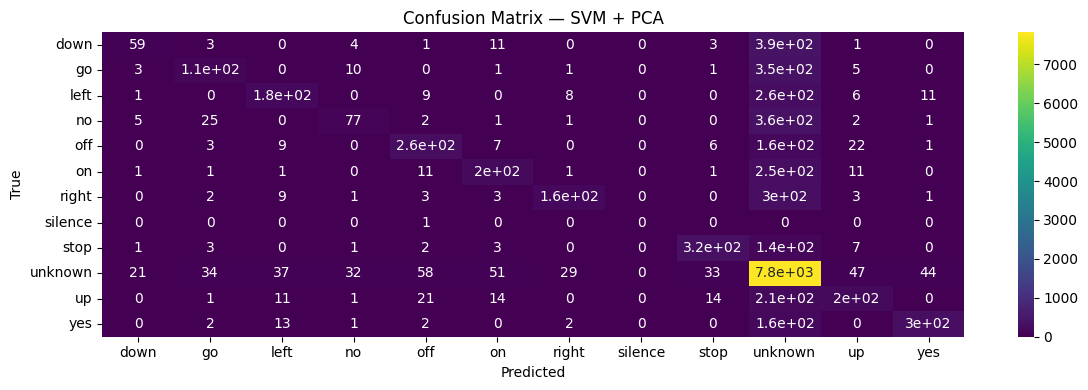

In [ ]:
# === 4) Basic accuracy ===
acc_svm = accuracy_score(y_val_enc, y_pred_enc_svm)
print("SVM + PCA - Validation Accuracy:", acc_svm)

# === 5) Decode to text labels for nicer analysis ===
y_true_svm = label_encoder.inverse_transform(y_val_enc)
y_pred_svm = label_encoder.inverse_transform(y_pred_enc_svm)
classes = label_encoder.classes_

print("\nSVM + PCA - Classification Report (all classes):")
print(classification_report(y_true_svm, y_pred_svm, labels=classes, target_names=classes))

# === Confusion matrix ===
cm_svm = confusion_matrix(y_true_svm, y_pred_svm, labels=classes)

plt.figure(figsize=(12, 4))
sns.heatmap(
    cm_svm,
    annot=True,              # True + fmt="d" si tu veux les nombres
    cmap="viridis",
    xticklabels=classes,
    yticklabels=classes
)
plt.title("Confusion Matrix — SVM + PCA")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Data processing before the CNN

In [ ]:
import numpy as np

N_MFCC = 40  
n_features = X_train.shape[1]
assert n_features % N_MFCC == 0, "Feature dimension must be divisible by N_MFCC"

n_frames = n_features // N_MFCC
print("n_frames:", n_frames, "| N_MFCC:", N_MFCC)

# Reshape: (N, n_features) -> (N, n_frames, N_MFCC)
X_train_seq = X_train.reshape(-1, n_frames, N_MFCC)
X_val_seq   = X_val.reshape(-1, n_frames, N_MFCC)

print("X_train_seq shape:", X_train_seq.shape)  # (N, n_frames, N_MFCC)
print("X_val_seq shape:", X_val_seq.shape)

n_frames: 32 | N_MFCC: 40
X_train_seq shape: (52880, 32, 40)
X_val_seq shape: (13221, 32, 40)


In [66]:
# Normalisation globale (sur le train)
mean_mfcc = X_train_seq.mean(axis=(0, 1), keepdims=True)
std_mfcc  = X_train_seq.std(axis=(0, 1), keepdims=True) + 1e-8

X_train_norm = (X_train_seq - mean_mfcc) / std_mfcc
X_val_norm   = (X_val_seq - mean_mfcc) / std_mfcc

# Ajout du canal : (N, time, freq, 1)
X_train_cnn = X_train_norm[..., np.newaxis]
X_val_cnn   = X_val_norm[..., np.newaxis]

print("X_train_cnn shape:", X_train_cnn.shape)  # (N, n_frames, N_MFCC, 1)
print("X_val_cnn shape:", X_val_cnn.shape)

X_train_cnn shape: (52880, 32, 40, 1)
X_val_cnn shape: (13221, 32, 40, 1)


## 11. Convolutional Neural Network (CNN)

A Convolutional Neural Network is trained on 2D MFCC representations.

By preserving the time–frequency structure of MFCCs, the CNN can learn local temporal and spectral patterns that classical models cannot capture.


In [67]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = len(label_encoder.classes_)
input_shape = X_train_cnn.shape[1:]   # (n_frames, N_MFCC, 1)

print("Input shape for CNN:", input_shape)
print("Num classes:", num_classes)

cnn_model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(16, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.4),

    layers.Dense(num_classes, activation="softmax")
])

cnn_model.summary()

cnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

Input shape for CNN: (32, 40, 1)
Num classes: 12


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 40, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 40, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 20, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 20, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 10, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 10, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 10, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,260 (739.30 KB)

 Trainable params: 189,036 (738.42 KB)

 Non-trainable params: 224 (896.00 B)

## 12. CNN Architecture

The CNN consists of several convolutional layers followed by batch normalization, max pooling, and fully connected layers.

Dropout is used to reduce overfitting.


In [68]:
from tensorflow.keras.callbacks import EarlyStopping

batch_size = 64
epochs = 30

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

history = cnn_model.fit(
    X_train_cnn,
    y_train_enc,
    validation_data=(X_val_cnn, y_val_enc),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
827/827 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.6558 - loss: 1.2219 - val_accuracy: 0.6909 - val_loss: 1.0436
Epoch 2/30
827/827 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.7359 - loss: 0.8214 - val_accuracy: 0.7540 - val_loss: 0.7615
Epoch 3/30
827/827 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.7819 - loss: 0.6669 - val_accuracy: 0.8070 - val_loss: 0.5842
Epoch 4/30
827/827 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.8138 - loss: 0.5704 - val_accuracy: 0.8208 - val_loss: 0.5488
Epoch 5/30
827/827 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.8336 - loss: 0.5061 - val_accuracy: 0.8536 - val_loss: 0.4511
Epoch 6/30
827/827 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.8509 - loss: 0.4530 - val_accuracy: 0.8663 - val_loss: 0.4267
Epoch 7/30
827/827 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.8607 - loss: 0.4143 - val_accuracy: 0.8613 - val_loss: 0.4315
Epoch 8/30
827/827 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8729 - loss: 0.3827 - 

414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
CNN - Validation Accuracy: 0.8942591331971863

CNN - Classification Report (all classes):
              precision    recall  f1-score   support

        down       0.85      0.68      0.76       472
          go       0.67      0.68      0.68       475
        left       0.84      0.82      0.83       471
          no       0.79      0.63      0.70       475
         off       0.88      0.83      0.85       471
          on       0.83      0.67      0.74       473
       right       0.90      0.82      0.86       473
     silence       1.00      0.99      1.00       276
        stop       0.92      0.85      0.89       476
     unknown       0.92      0.96      0.94      8208
          up       0.84      0.84      0.84       475
         yes       0.93      0.90      0.92       476

    accuracy                           0.89     13221
   macro avg       0.86      0.81      0.83     13221
weighted avg       0.89      0.89      0.89     13221



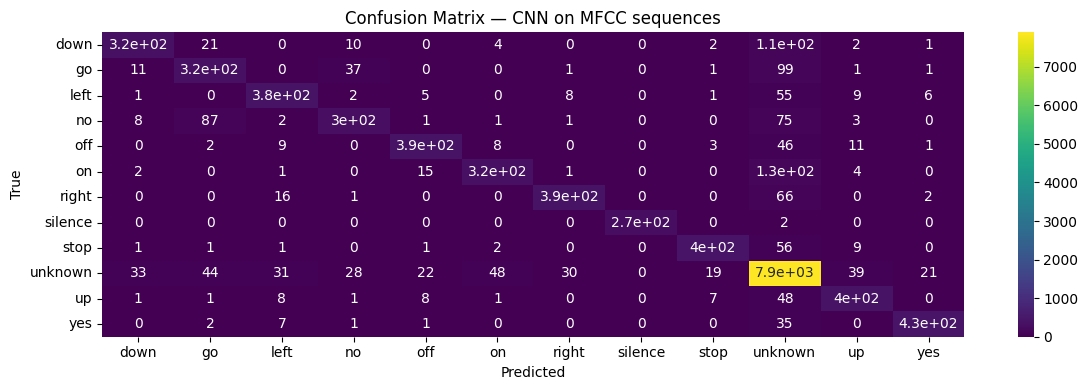

In [69]:
# === Predict on validation set ===
y_pred_proba_cnn = cnn_model.predict(X_val_cnn)
y_pred_enc_cnn = np.argmax(y_pred_proba_cnn, axis=1)

# Accuracy
acc_cnn = accuracy_score(y_val_enc, y_pred_enc_cnn)
print("CNN - Validation Accuracy:", acc_cnn)

# Decode to text labels
y_true_cnn = label_encoder.inverse_transform(y_val_enc)
y_pred_cnn = label_encoder.inverse_transform(y_pred_enc_cnn)
classes = label_encoder.classes_

print("\nCNN - Classification Report (all classes):")
print(classification_report(y_true_cnn, y_pred_cnn, labels=classes, target_names=classes))

# Confusion matrix
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn, labels=classes)

plt.figure(figsize=(12, 4))
sns.heatmap(
    cm_cnn,
    annot=True,
    cmap="viridis",
    xticklabels=classes,
    yticklabels=classes
)
plt.title("Confusion Matrix — CNN on MFCC sequences")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## Discussion

The results highlight several key points:
- linear models struggle with class imbalance and temporal information
- SVM improves performance but remains limited
- the CNN significantly outperforms classical models by exploiting 2D MFCC structure


## Conclusion

This notebook demonstrates a complete speech command recognition pipeline, from raw audio preprocessing to deep learning-based classification.

The CNN achieves the best performance, confirming the importance of time–frequency representations for speech-related tasks.
